In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## Wczytanie danych

In [12]:
sciezka = os.getcwd()
plik = os.path.join(sciezka,'apf_data.xlsx')
print(sciezka)
print(plik)

c:\Users\s-A009-27\Downloads\Zaj6
c:\Users\s-A009-27\Downloads\Zaj6\apf_data.xlsx


In [13]:
ramka = pd.read_excel(plik, sheet_name = '1', header=0)
ramka.set_index(['countrycode', 'year'], inplace=True)
ramka.head()

rgdpna       rnna       emp
countrycode year                                
ARG         2010  13.759205  14.761623  2.894626
            2011  13.817511  14.801410  2.917123
            2012  13.807194  14.831745  2.933394
            2013  13.830963  14.861097  2.950966
            2014  13.805516  14.884328  2.964399

In [14]:
print('rozmiar danych:', ramka.shape)
print('typ danych:', type(ramka))

rozmiar danych: (330, 3)
typ danych: <class 'pandas.core.frame.DataFrame'>


## Tworzenie zmiennych y, X

In [15]:
y = ramka[['rgdpna']] # y = ramka.rdpna
print('y type:', type(y), '\ny size:', y.shape)

x0 = pd.DataFrame(np.ones(y.shape), index=ramka.index, columns=['const'])
X = pd.concat([x0, ramka[['rnna', 'emp']]],axis=1)
print('X rozmiar:', X.shape)
print('X typ:', type(X))
print(X.head(3))

y type: <class 'pandas.core.frame.DataFrame'> 
y size: (330, 1)
X rozmiar: (330, 3)
X typ: <class 'pandas.core.frame.DataFrame'>
                  const       rnna       emp
countrycode year                            
ARG         2010    1.0  14.761623  2.894626
            2011    1.0  14.801410  2.917123
            2012    1.0  14.831745  2.933394


## A priori, przygotowanie do a posteriori, dane do symulacji

In [16]:
(T, k) = X.shape

# rozkład a priori dla bet

b_pr = np.zeros(k)
C_pr = np.eye(k)*0.01
#print(C_pr.shape)
V_pr = np.linalg.inv(C_pr) # przeliczanie odwrotności macierzy
# rozkład a priori dla tau
w_pr = 0.01
z_pr = 0.01
# tu: E(tau)=w_pr/z_pr, V(tau) = w_pr/(z_pr**2)

# a posteriori

w_tl = (T+2*w_pr)/2 # w tylda
Cb_pr = C_pr @ b_pr
#print(C_pr.shape)
Xnp = X.to_numpy()
ynp = y.to_numpy()
xtrx = Xnp.T @ Xnp # x transponowane * x
xtry = (Xnp.T @ ynp).flatten() # x transponowane * y
print(Xnp.shape)

# do symulacji

spalonych = 200
przyjetych = 1000 # można przyjąć 10 000 żeby mieć ładniejsze wyniki
iteracje = spalonych + przyjetych

losyBet = np.zeros((przyjetych,k))
losyTau = np.zeros((przyjetych,1))

# ustalam wartosc poczatkowa

tau = 1
import time
poczatek = time.perf_counter()

(3, 3)
(3,)
(330, 3)


## Próbnik Gibbsa

In [17]:
for i in range(0,iteracje,1):
    # losowania z r. normalnego (bet)
    cov_b = np.linalg.inv(C_pr + tau * xtrx)
    mean_b = cov_b @ (Cb_pr + tau * xtry) # musi być jednowymiarowa tablica typu numpy
    b = np.random.multivariate_normal(mean_b,cov_b)
    # losowania z r. gamma (tau)
    z_tl = 0.5*(2*z_pr + (ynp.flatten() - Xnp @ b).T @ (ynp.flatten() - Xnp @ b)) # z tylda; ynp.flatten() bo y jest dwuwymiarowy a nie jednowymiarowy
    tau = np.random.gamma(w_tl)/z_tl
    if i >= spalonych:
        losyBet[i-spalonych, :] = b
        losyTau[i-spalonych] = tau

# statystyki z symulacji

Bayes_beta = np.c_[losyBet.mean(0), losyBet.std(0)]
Bayes_tau = np.c_[losyTau.mean(0), losyTau.std(0)]

#np.savetxt('wynikiBayes.csv', np.r_[Bayes_beta, Bayes_tau], delimiter=';')
print(np.r_[Bayes_beta, Bayes_tau])

[[4.02761120e+00 3.09851416e-01]
 [5.62829422e-01 2.40294001e-02]
 [4.68946559e-01 2.47035838e-02]
 [2.60000593e+01 2.01303047e+00]]


## Wykres rozrzutu

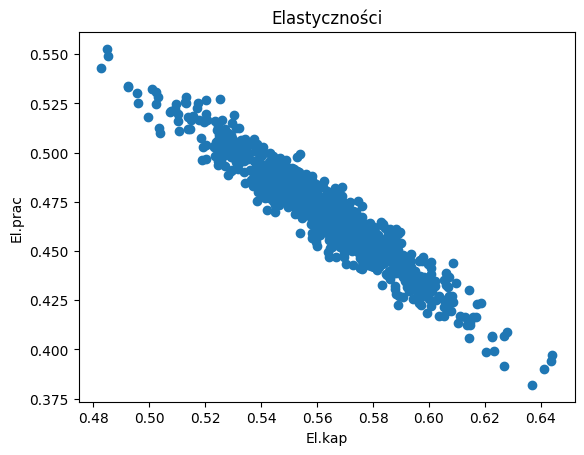

In [21]:
h3 = plt.figure()
plt.scatter(losyBet[:,1], losyBet[:,2])
plt.title('Elastyczności')
plt.xlabel('El.kap')
plt.ylabel('El.prac')
plt.show()

## Histogram dla s2

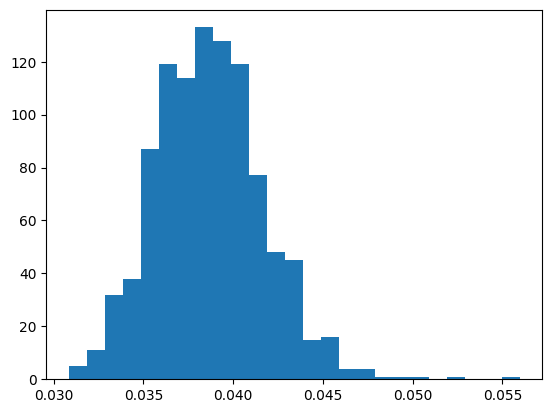

In [19]:
losyS2 = 1/losyTau
h4 = plt.figure()
plt.hist(losyS2, bins=25)
plt.show()
h4.savefig('histogram_dla_s2.png')